# Install and import libraries

In [ ]:
!pip install torchinfo

import gc
import os
import torch
import gdown
import joblib
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from pprint import pprint
from torchinfo import summary
from google.colab import drive
import matplotlib.pyplot as plt
from torch.amp import GradScaler
from torch.optim.lr_scheduler import StepLR
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, random_split, Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, accuracy_score, make_scorer, log_loss

# Download TinyStories Dataset

In [ ]:
!pip install -U "datasets==3.6.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
### YOU MUST NOT CHANGE THIS CELL! ###

from datasets import load_dataset

full_dataset = load_dataset("skeskinen/TinyStories-GPT4", split="train")
full_dataset = full_dataset.remove_columns([c for c in full_dataset.column_names if c not in ["story", "features"]])
assert len(full_dataset) == 2745100

splits = full_dataset.train_test_split(test_size=10000, seed=42, shuffle=True)

train_dataset = splits["train"]
test_dataset  = splits["test"]

assert len(train_dataset) == 2735100
assert len(test_dataset)  == 10000

assert train_dataset[0]["story"][:33] == "One day, a little girl named Lily"
assert train_dataset[0]["features"] == ["Dialogue", "Conflict"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/554 [00:00<?, ?B/s]

data/train-00000-of-00008-c63ccd5d5290f4(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00001-of-00008-478199d8ac0449(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00002-of-00008-9b868f59be94d8(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00003-of-00008-d183cca02834cd(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00004-of-00008-5f8ac0bb66de58(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00005-of-00008-e8c22c3e776b87(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00006-of-00008-941f57106aca33(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00007-of-00008-771d8aa2d5ce5c(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2745100 [00:00<?, ? examples/s]

# Notebook execution modes
*   **TRAIN_MODE**: train, validate, test the model and save its parameters.
*   **TEST_MODE**: load trained model parameters and test the model.

These modes are intended to solely handle the notebook's behavior during runtime (i.e., which cells or procedures are executed).

In [ ]:
def set_mode(mode='TEST'):
  """
  Allows to choose if running in train mode or test mode.
  -----------
  Parameters:
  -----------
  - mode: 'TRAIN' or 'TEST' (default)
  """
  if mode == 'TRAIN':
    TRAIN = True
    TEST = False
    return TRAIN, TEST
  elif mode == 'TEST':
    TRAIN = False
    TEST = True
    return TRAIN, TEST
  else:
        raise ValueError("Mode must be 'TRAIN' or 'TEST'")

# Choosing how to execute the code
TRAIN_MODE, TEST_MODE = set_mode(mode='TEST')

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Implementation of a multinomial logistic regression by using a one-versus-the-rest classifier

## Configure environment

In [ ]:
if TRAIN_MODE:
  # Accessing drive
  drive.mount('/content/drive', force_remount=True)
  folder_path = '/content/drive/MyDrive/savedParams/'

  # Creating folder
  os.makedirs(folder_path, exist_ok=True)
  best_model1_path = os.path.join(folder_path, "best_model.joblib")
  best_thresholds1_path = os.path.join(folder_path, "best_thresholds.joblib")

if TEST_MODE:
  # Downloading prevoiusly saved parameters
  best_model1_drive_link = 'https://drive.google.com/file/d/1kE-qJ-6Idwci000Zozjkb4uuwV2ah3Sl/view?usp=sharing'
  thresholds1_drive_link = 'https://drive.google.com/file/d/1RbWIWzm4yndqZ1m5vkLMd9H_bwsO4F69/view?usp=sharing'

  # Extracting file ids
  best_model1_id = best_model1_drive_link.split('/')[-2]
  thresholds1_id = thresholds1_drive_link.split('/')[-2]

  # Downloaded file names
  best_model1_filename = 'best_model.joblib'
  thresholds1_filename = 'best_thresholds.joblib'

  # Downloading
  print(f"Downloading {best_model1_filename}...")
  gdown.download(id=best_model1_id, output=best_model1_filename, quiet=False)
  print(f"Downloading {thresholds1_filename}...")
  gdown.download(id=thresholds1_id, output=thresholds1_filename, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1kE-qJ-6Idwci000Zozjkb4uuwV2ah3Sl
To: /content/best_model.joblib
100%|██████████| 252k/252k [00:00<00:00, 4.71MB/s]


Downloading...
From: https://drive.google.com/uc?id=1RbWIWzm4yndqZ1m5vkLMd9H_bwsO4F69
To: /content/best_thresholds.joblib
100%|██████████| 287/287 [00:00<00:00, 1.17MB/s]


## Prepare dataset

In [ ]:
MAX_TRAIN_SAMPLES = 50_000

# Dividing stories stories from fratures in the train and test sets
x_train = train_dataset[:MAX_TRAIN_SAMPLES]["story"]
y_train = train_dataset[:MAX_TRAIN_SAMPLES]["features"]

x_test = test_dataset["story"]
y_test = test_dataset["features"]

# Splitting train dataset into train_new dataset and validation dataset
x_train_new, x_validation, y_train_new, y_validation = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=42)

assert len(x_train_new) == 40000
assert len(x_validation) == 10000
assert len(x_train_new) == len(y_train_new)
assert len(x_validation) == len(y_validation)
assert len(x_test) == len(y_test)

In [ ]:
# Defining the label used
TAGS = ["BadEnding", "Conflict", "Dialogue", "Foreshadowing", "MoralValue", "Twist"]

mlb = MultiLabelBinarizer(classes=TAGS) # converts strings into a list of booleans

# Converting labels into a list of booleans associated with the respective classes
y_train_encoded = mlb.fit_transform(y_train_new)
y_validation_encoded = mlb.transform(y_validation)

## Preparing the model

In [ ]:
if TRAIN_MODE:
  # Defining a TF-IDF vectorizer for words
  word_vectorizer = TfidfVectorizer(stop_words="english", dtype=np.float32)

  # Defining a TF-IDF vectorizer for char
  char_vectorizer = TfidfVectorizer(analyzer="char", dtype=np.float32)

  # Combining word and character features using FeatureUnion
  combined_features = FeatureUnion([('word_features', word_vectorizer), ('char_features', char_vectorizer)])

  # Defining a logistic regression model
  model = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")

  # Defining a one vs rest classifier, i.e. fits one classifier per class
  classifier = OneVsRestClassifier(model)

  # Pipeline allows to sequentially apply a list of transformers to preprocess data
  pipeline = Pipeline([("vectorizer", combined_features), ("classifier", classifier)])

## Training and validation of the model

In [ ]:
if TRAIN_MODE:
  def multilabel_loss(y_true, y_model):
      """
      Computes the loss for a multilabel classification problem.
      -----------
      Parameters:
      -----------
      - y_true: true labels
      - y_model: predicted labels
      """
      losses = []
      for i in range(y_true.shape[1]):
          losses.append(log_loss( y_true[:, i], y_model[:, i], labels=[0, 1]))
      return np.mean(losses)

In [ ]:
if TRAIN_MODE:
  # Setting parameters for the k-fold validation
  # Parameters now target the 'word_features' component of the FeatureUnion
  parameters_for_kfold = {
      "vectorizer__word_features__max_features": [10000],
      "vectorizer__char_features__max_features": [1000],
      "vectorizer__word_features__ngram_range": [(1, 1), (1, 2)],
      "vectorizer__char_features__ngram_range": [(1, 1), (1, 2)],
      "vectorizer__word_features__min_df": [200],
      "classifier__estimator__C": [0.1, 1, 10, 100]
  }

  # Defining a f1 scorer, loss scorer and total scorer
  f1_scorer = make_scorer(f1_score, average="macro", zero_division=0) # here macro is important to evaluate the model
  log_loss_scorer = make_scorer(multilabel_loss)
  total_scorer = {"f1_macro": f1_scorer,"log_loss": log_loss_scorer}

  # Defining the k-fold validation
  kfold = GridSearchCV(estimator=pipeline, param_grid=parameters_for_kfold, scoring=total_scorer, refit="f1_macro", cv=3, verbose=2, return_train_score=True)

### K-fold validation

In [ ]:
if TRAIN_MODE:
  # Performing the k-fold validation
  kfold.fit(x_train_new, y_train_encoded)

  # Access the mean test log_loss for the best estimator
  best_log_loss = kfold.cv_results_['mean_test_log_loss'][kfold.best_index_]

  # Printing k-fold results
  print("\n=== Grid search results ===")
  print("Best score f1:", kfold.best_score_)
  print(f"Log Loss for the best model: {best_log_loss:.4f}")
  print("\nBest hyperparameters:")
  pprint(kfold.best_params_)

In [ ]:
if TRAIN_MODE:
  # Plotting k-fold parameters results
  results = pd.DataFrame(kfold.cv_results_)

  plt.figure(figsize=(10, 6))

  # Get unique combinations of ngram_range for word and char features
  unique_ngram_combinations = results[['param_vectorizer__word_features__ngram_range', 'param_vectorizer__char_features__ngram_range']].drop_duplicates()

  for index, row in unique_ngram_combinations.iterrows():
      word_ngram = row['param_vectorizer__word_features__ngram_range']
      char_ngram = row['param_vectorizer__char_features__ngram_range']

      # Filter results for the current ngram combination
      subset = results[(results['param_vectorizer__word_features__ngram_range'] == word_ngram) & (results['param_vectorizer__char_features__ngram_range'] == char_ngram)]

      # Plot for the current combination
      subset = subset.sort_values(by='param_classifier__estimator__C')
      plt.plot(subset["param_classifier__estimator__C"], subset["mean_test_f1_macro"], marker='o', label=f"word_ngram={word_ngram}, char_ngram={char_ngram}")

  plt.xscale("log")
  plt.xlabel("C (Regularization strength)", fontsize=16)
  plt.ylabel("F1 score (macro)", fontsize=16)
  plt.legend()
  plt.grid(True)
  plt.show()

### Best model selection

In [ ]:
if TRAIN_MODE:
  # Saving the best model parameters
  best_model = kfold.best_estimator_

  # Training using the best model parameters and predicting values for the validation
  best_model.fit(x_train_new, y_train_encoded)
  y_pred_prob = best_model.predict_proba(x_validation)

In [ ]:
if TRAIN_MODE:
  def best_threshold(y_val_predicted_probability, y_val_true_encoded):
    """
    Evaluates the best threshold for each label.
    -----------
    Parameters:
    -----------
    - y_val_predicted_probability: predicted probabilities
    - y_val_true_encoded: true labels
    """
    thresholds = np.arange(0.0, 1.01, 0.01)
    best_thresholds = {}

    # selecting the best thresholds for each label
    for i, tag in enumerate(TAGS):
      best_f1 = 0
      best_t = 0.5

      for t in thresholds:
        y_tag_pred = (y_val_predicted_probability[:,i]>=t).astype(int)
        f1 = f1_score(y_val_true_encoded[:,i], y_tag_pred)

        if f1 > best_f1:
          best_f1 = f1
          best_t = t

      best_thresholds[tag] = best_t
      print(f"Best threshold for {tag}: {best_t:.2f}, f1: {best_f1:.4f} ")

    assert len(best_thresholds) == len(TAGS)

    return best_thresholds

In [ ]:
def y_prob_to_y_pred(y_prob, thresholds, tags):
  """
  Converts the predicted probabilities to binary predictions for each label.
  -----------
  Parameters:
  -----------
  - y_prob: predicted probabilities
  - thresholds: thresholds for each class
  - tags: full list of labels
  """

  y_pred = np.zeros_like(y_prob, dtype=int)

  for i, tag in enumerate(tags):
    y_pred[:,i] = (y_prob[:,i]>= thresholds[tag]).astype(int)

  return y_pred

def evaluate(y_model, y_true, thresholds, tags):
  """
  Evaluates the model's accuracy and f1 score class by class.
  -----------
  Parameters:
  -----------
  - y_model: predicted probabilities
  - y_true: true labels
  - thresholds: thresholds for each class
  - tags: full list of labels
  """
  y_pred = y_prob_to_y_pred(y_model, thresholds, tags)

  results = {}

  for i, tag in enumerate(tags):
    accuracy = accuracy_score(y_true[:, i], y_pred[:, i])
    f1 = f1_score(y_true[:, i], y_pred[:, i])
    results[tag] = {"accuracy": accuracy, "f1": f1}

  assert len(results) == len(tags)

  return results

def f1_macro_score(results):
  """
  Computes the macro F1 score.

  -----------
  Parameters:
  -----------
  - results: evaluation results
  """

  f1_scores = [result["f1"] for result in results.values()]
  f1_macro = sum(f1_scores) / len(f1_scores)

  return f1_macro

def print_results(results, tags, test=True):
  """
  Prints out the results of the evaluation of the model.
  -----------
  Parameters:
  -----------
  - results: evaluation results
  - tags: full list of labels
  - test: 'True' is default and is referred to the test set, 'False' if is referred to the validation set
  """

  if test:
    print("\n=== Test results ===")
  else:
    print("\n=== Validation results ===")

  for i, tag in enumerate(tags):
    print(f"{tag}:")
    print(f"  Accuracy: {results[tag]['accuracy']:.4f}")
    print(f"  F1 score: {results[tag]['f1']:.4f}")
    print("\n")

  print(f"Macro F1 score: {f1_macro_score(results):.4f}")

In [ ]:
if TRAIN_MODE:
  # Choosing best thresholds on the validation set
  best_thresholds = best_threshold(y_pred_prob, y_validation_encoded)

  # Evaluating model on the validation set
  results = evaluate(y_pred_prob, y_validation_encoded, best_thresholds, TAGS)

  # Printing results for the validation set
  print_results(results, TAGS, test=False)

In [ ]:
def roc_per_tag(y_true, y_model, tags):
  """
  Plots the ROC curve for each label.
  -----------
  Parameters:
  -----------
  - y_true: true labels
  - y_model: predicted probabilities
  - tags: full list of labels
  """

  plt.figure(figsize=(10, 8))

  for i, tag in enumerate(tags):
    false_positives, true_positives, _ = roc_curve(y_true[:, i], y_model[:, i])
    roc_auc = auc(false_positives, true_positives)
    plt.plot(false_positives, true_positives, label=f"{tag} (AUC = {roc_auc:.3f})")

  plt.plot([0,1], [0,1] , "k--")
  plt.xlabel("False positive rate", fontsize=16)
  plt.ylabel("True positive rate", fontsize=16)
  plt.title("ROC curves per label")
  plt.legend(loc="lower right")
  plt.grid(True)
  plt.show()

  final_roc_auc_score = roc_auc_score(y_true, y_model)
  print(f"Area under the ROC curve: {final_roc_auc_score:.4f}")

def confusion_matrices(y_true, y_model, tags):
  """
  Plots the confusion matrix for each label.
  -----------
  Parameters:
  -----------
  - y_true: true labels
  - y_model: predicted probabilities
  - tags: full list of labels
  """

  for i, tag in enumerate(tags):

    confusion_matr  = confusion_matrix(y_true[:,i], y_model[:,i])

    sns.heatmap(confusion_matr, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion matrix for {tag}")
    plt.xlabel("Predicted label", fontsize=16)
    plt.ylabel("True label", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
if TRAIN_MODE:
  # Plots the ROC curves and the confusion matrices for the validation set
  y_pred = y_prob_to_y_pred(y_pred_prob, best_thresholds, TAGS)
  roc_per_tag(y_validation_encoded, y_pred_prob, TAGS)
  confusion_matrices(y_validation_encoded, y_pred, TAGS)

### Saving best model parameters

In [ ]:
if TRAIN_MODE:
  # Saving best model and best thresholds on a file
  SAVE_BEST_MODEL = False
  if SAVE_BEST_MODEL:
    joblib.dump(best_model, folder_path + "best_model.joblib")
    joblib.dump(best_thresholds, folder_path + "best_thresholds.joblib")

In [ ]:
# Preparing for the test part if train was performed
if TRAIN_MODE:
  TRAIN_MODE, TEST_MODE = set_mode(mode='TEST')

## Testing the best model

In [ ]:
if TEST_MODE:
  # Uploading best model parameters and thresholds
  best_model = joblib.load("best_model.joblib")
  best_thresholds = joblib.load("best_thresholds.joblib")

In [ ]:
if TEST_MODE:
  # Test the model and final results
  y_test_pred_prob = best_model.predict_proba(x_test)
  y_test_encoded = mlb.transform(y_test)
  test_results = evaluate(y_test_pred_prob, y_test_encoded, best_thresholds, TAGS)
  print_results(test_results, TAGS)


=== Test results ===
BadEnding:
  Accuracy: 0.9607
  F1 score: 0.7911


Conflict:
  Accuracy: 0.8822
  F1 score: 0.3990


Dialogue:
  Accuracy: 0.9021
  F1 score: 0.9130


Foreshadowing:
  Accuracy: 0.8822
  F1 score: 0.4062


MoralValue:
  Accuracy: 0.9599
  F1 score: 0.8090


Twist:
  Accuracy: 0.9329
  F1 score: 0.8290


Macro F1 score: 0.6912


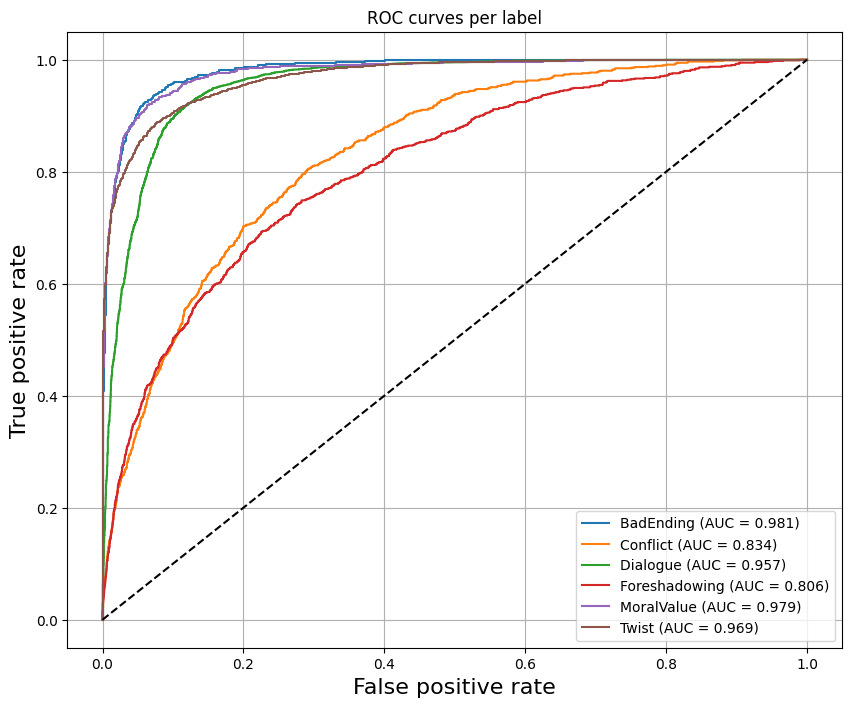

Area under the ROC curve: 0.9210


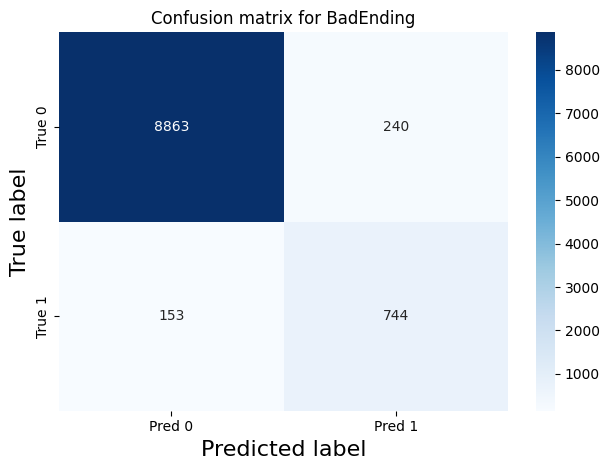

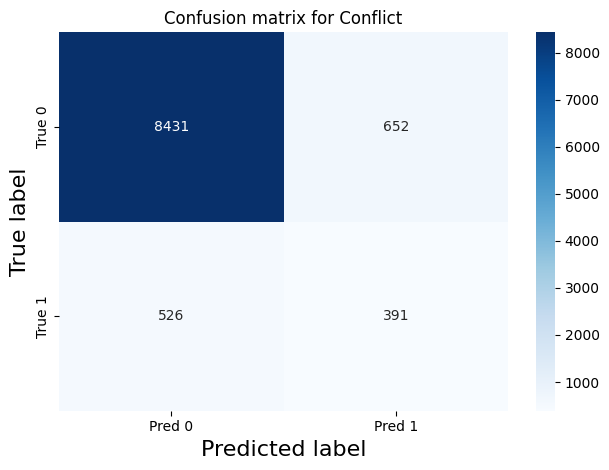

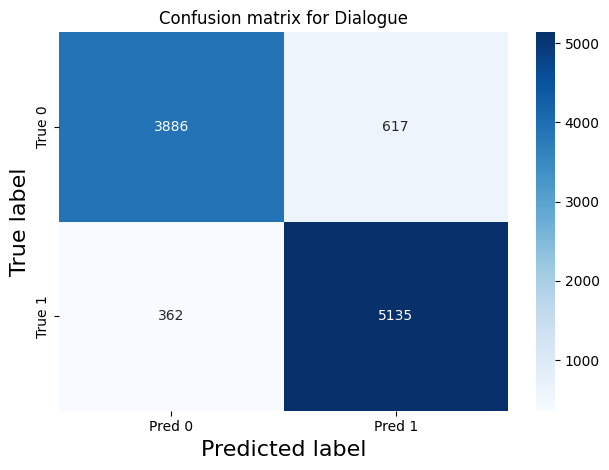

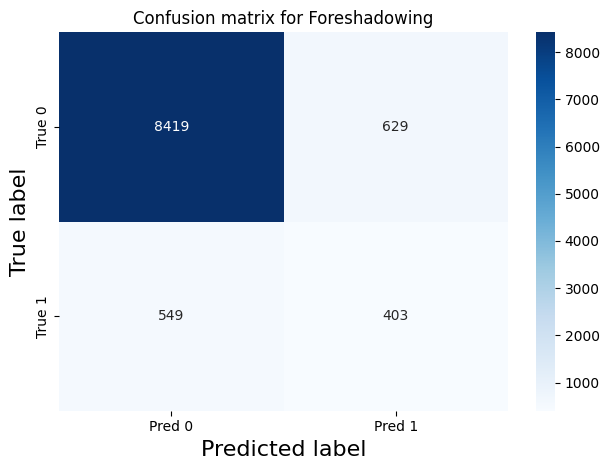

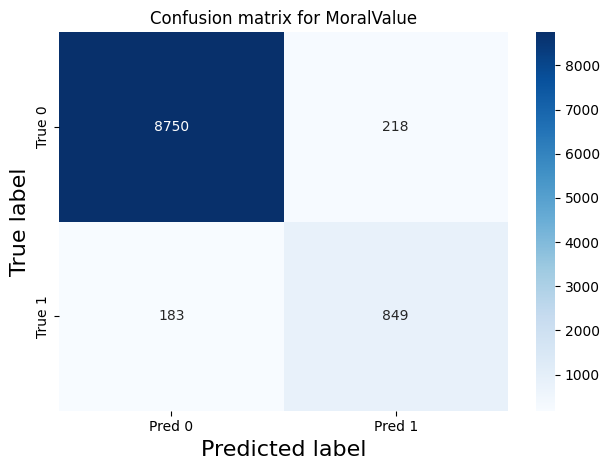

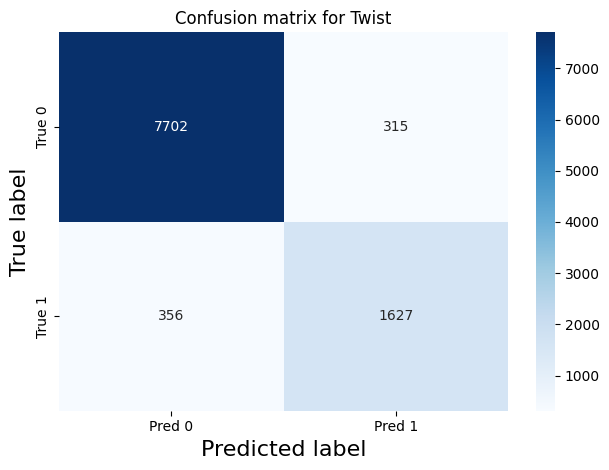

In [ ]:
if TEST_MODE:
  # Plots the ROC curves and the confusion matrices for the test set
  y_test_pred = y_prob_to_y_pred(y_test_pred_prob, best_thresholds, TAGS)
  roc_per_tag(y_test_encoded, y_test_pred_prob, TAGS)
  confusion_matrices(y_test_encoded, y_test_pred, TAGS)

# 2. Implementation of Transformer architecture using pre-trained DistilBERT model

## Configure environment

In [ ]:
# Choosing how to execute the code
TRAIN_MODE, TEST_MODE = set_mode(mode='TEST')

In [ ]:
# To ensure reproducibility, set seeds
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

if TRAIN_MODE:
  # Mount driver and set folder to save parameters
  drive.mount('/content/drive')
  folder_path = "/content/drive/MyDrive/savedParams512ML"
  os.makedirs(folder_path, exist_ok=True)

  # Set paths of model parameters and best thresholds
  params2_final_path = os.path.join(folder_path, "model2_final_params.pth")
  best_thresholds2_path = os.path.join(folder_path, "best_thresholds2.joblib")

if TEST_MODE:
  # Set public links to load model parameters and best thresholds
  params2_final_url = "https://drive.google.com/file/d/1K-fKaJMWuKYEJTAKMBuwFYOnb8sW_DCS/view?usp=drive_link"
  best_thresholds2_url = "https://drive.google.com/file/d/1S-TF87FTGf9xxrc34DWCGRNO1OFXEOdX/view?usp=sharing"
  gdown.download(params2_final_url, "model2_final_params.pth", fuzzy=True, quiet=False)
  gdown.download(best_thresholds2_url, "best_thresholds2.joblib", fuzzy=True, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1K-fKaJMWuKYEJTAKMBuwFYOnb8sW_DCS
From (redirected): https://drive.google.com/uc?id=1K-fKaJMWuKYEJTAKMBuwFYOnb8sW_DCS&confirm=t&uuid=5096705b-d6b0-4d97-8ccf-3e43c8d4b96f
To: /content/model2_final_params.pth
100%|██████████| 268M/268M [00:06<00:00, 39.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1S-TF87FTGf9xxrc34DWCGRNO1OFXEOdX
To: /content/best_thresholds2.joblib
100%|██████████| 216/216 [00:00<00:00, 1.03MB/s]


In [ ]:
# Labels of stories
TAGS = ["BadEnding", "Conflict", "Dialogue", "Foreshadowing", "MoralValue", "Twist"]

# Use first MAX_TRAIN_SAMPLES of stories
MAX_TRAIN_SAMPLES = 50_000
full_train_dataset = train_dataset.select(range(MAX_TRAIN_SAMPLES))

# Calculate average and maximum lengths of stories in MAX_TRAIN_SAMPLES
lengths = [len(story.split()) for story in full_train_dataset["story"]]
AVERAGE_LENGTH = (sum(lengths) // len(lengths))
MAX_LENGTH_DATA = max(lengths)
print(f"Average story length: {AVERAGE_LENGTH}")
print(f"Maximum story length: {MAX_LENGTH_DATA}")

# Set hyperparameters
EPOCHS = 5
BATCH_SIZE = 64
DEF_THRESHOLDS = [0.5 for i in range(6)]
LEARNING_RATE = 0.001 # for optimizer
WEIGHT_DECAY = 0.01   # for L2 regularization
MAX_LENGTH = 512      # fixed to BERT context window

Average story length: 160
Maximum story length: 878


## Prepare dataset

### Split full training dataset into training and validation subsets

In [ ]:
# Split dataset into 80% train and 20% validation subsets
train_val_splits = full_train_dataset.train_test_split(test_size=0.2, shuffle=True, seed=SEED)
train_subset = train_val_splits["train"]
val_subset = train_val_splits["test"]

print(
    "Dataset sizes:\n"
    f"  Full training set: {len(full_train_dataset)}\n"
    f"  Train subset     : {len(train_subset)}\n"
    f"  Validation set   : {len(val_subset)}"
)

Dataset sizes:
  Full training set: 50000
  Train subset     : 40000
  Validation set   : 10000


### Encode true labels into multi-hot vectors

In [ ]:
def encode_labels(labels, tags, mlb=None):
    """
    Returns encoded labels and multi-label binarizer.

    ----------
    Parameters
    ----------
    labels: list of lists containing labels for each sample
    tags  : list of all classes
    mlb   : multi-label binarizer
    """

    if mlb is None:
        mlb = MultiLabelBinarizer(classes=tags)
        encoded_labels = mlb.fit_transform(labels) # Used for training
    else:
        mlb = mlb
        encoded_labels = mlb.transform(labels) # Used for evaluation

    return encoded_labels, mlb

In [ ]:
# Training subset and validation subset
y_train_data, mlb1 = encode_labels(train_subset["features"], TAGS)
y_val_data, _ = encode_labels(val_subset["features"], TAGS, mlb=mlb1)

# Full training set and test set
y_full_train_data, mlb2 = encode_labels(full_train_dataset["features"], TAGS)
y_test_data, _ = encode_labels(test_dataset["features"], TAGS, mlb=mlb2)

### Check imbalance per class and among classes

In [ ]:
def class_imbalances(encoded_labels, tags):
    """
    Compute per-class imbalance and imbalance among classes for multi-label classification.
    Returns pos_weight (neg/positive ratio, that is the imbalance per class).

    ----------
    Parameters
    ----------
    encoded_labels: list of lists containing encoded true labels for each sample
    tags          : list of all classes
    """

    # Transform to numpy array
    en_labels = np.array(encoded_labels)

    # Sum positives per class
    pos_class = np.sum(en_labels, axis=0)

    # Compute negatives per class
    neg_class = en_labels.shape[0] - pos_class

    # Neg/pos is imbalance per class (computed safely)
    pos_weight = torch.where(
        torch.tensor(pos_class) > 0,
        torch.tensor(neg_class) / torch.tensor(pos_class),
        torch.zeros_like(torch.tensor(pos_class), dtype=torch.float)
    )

    assert (pos_weight.shape[0] == (len(tags)))

    # Print class proportion
    total_positives = np.sum(pos_class)
    class_proportion = pos_class / total_positives

    # Print Pandas table
    df = pd.DataFrame({
        "Tags": tags,
        "Positives [%]": class_proportion * 100,
        "Neg / pos": pos_weight.numpy(),
    })
    print(df.to_string(
        index=False,
        formatters={
            "Positives [%]": "{:.2f}".format,
            "Neg / pos": "{:.2f}".format
        }
    ))

    return pos_weight

In [ ]:
print("Imbalance on training subset:")
pos_weight_sub = class_imbalances(y_train_data, TAGS)

print("\nImbalance on full training set:")
pos_weight_full = class_imbalances(y_full_train_data, TAGS)

print("\nImbalance on validation set:")
imb_val = class_imbalances(y_val_data, TAGS)

print("\nImbalance on test set:")
imb_test = class_imbalances(y_test_data, TAGS)

Imbalance on training subset:
         Tags Positives [%] Neg / pos
    BadEnding          8.13     10.10
     Conflict          8.15     10.07
     Dialogue         48.62      0.86
Foreshadowing          8.29      9.89
   MoralValue          9.02      9.01
        Twist         17.79      4.08

Imbalance on full training set:
         Tags Positives [%] Neg / pos
    BadEnding          8.16     10.07
     Conflict          8.13     10.11
     Dialogue         48.62      0.86
Foreshadowing          8.25      9.95
   MoralValue          9.00      9.03
        Twist         17.84      4.06

Imbalance on validation set:
         Tags Positives [%] Neg / pos
    BadEnding          8.25      9.96
     Conflict          8.03     10.26
     Dialogue         48.65      0.86
Foreshadowing          8.06     10.22
   MoralValue          8.95      9.11
        Twist         18.06      4.01

Imbalance on test set:
         Tags Positives [%] Neg / pos
    BadEnding          7.95     10.15
     Conf

### Create daughter class to build custom PyTorchDataset

In [ ]:
class PyTorchDataset(Dataset):

    # Class constructor
    def __init__(self, stories, encoded_labels, tokenizer, max_length):
        """
        Prepare the dataset for DataLoader.

        ----------
        Parameters
        ----------
        stories       : list of lists containing stories for each sample
        encoded_labels: encoded labels
        tokenizer     : used tokenizer for stories
        max_length    : max token length for each sample
        """
        # Tokenize stories passing or truncating at max_length
        self.tokenized_stories = tokenizer(
            stories,
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

        # Store encoded labels
        self.labels = torch.tensor(encoded_labels, dtype=torch.float)

        # Consistency check
        assert len(self.tokenized_stories["input_ids"]) == len(self.labels)

    def __len__(self):
        """
        Returns number of stories.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Returns a dictionary compatible with PyTorch.
        """
        return {
            "input_ids": self.tokenized_stories["input_ids"][idx],
            "attention_mask": self.tokenized_stories["attention_mask"][idx],
            "features": self.labels[idx]
        }

## Post-training implementation via DistilBERT tokenizer and DistilBERT model

### Define training and evaluation function

In [ ]:
def train(model, optimizer, train_data, val_data, batch_size, epochs, pos_weight, thresholds, device):
    """
    Defines the training algorithm of a multi-label classification model using
    binary cross-entropy loss with logits. During each epoch, the model is
    trained applying gradient descent algorithm to mini-batches. Parameters are
    updated through a decreasing learning rate. After each epoch, the model is
    evaluated on a validation dataset.
    """

    # Move to current device
    model.to(device)
    pos_weight = pos_weight.to(device)

    # Reduce learning rate during training by a factor gamma
    step_size = round(epochs * 3/4)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)

    # Load training and validation dataset
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Combine a Sigmoid layer and the BCE train loss in one single class
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # pos_weight handles class imbalance

    # Scale the loss to avoid gradient values underflowing to zero
    scaler = torch.amp.GradScaler('cuda')

    for epoch in range(epochs):

        # Set model to training mode
        model.train()

        # Accumulator for training losses
        losses = []

        for batch in train_loader:

            # Move tokenized text inputs, attention mask and targets to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            target = batch["features"].to(device)

            # Clear gradients from previous batch iteration and forward pass
            optimizer.zero_grad()

            # Use Automatic Mixed Precision to speed up computations
            with torch.amp.autocast('cuda'):
                logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
                loss = loss_fn(logits, target)

            # Sanity check used during debug
            # assert (logits.shape == target.shape)

            # Scale and unscale gradients while computing loss and backpropagating
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            losses.append(loss.item())

        print("=" * 45)
        print(f'Train epoch: {epoch+1}/{epochs},  Train loss: {np.mean(losses):.4f}')

        if val_data is not None:
          # Evaluate model performance on validation set
          _, _ = evaluate2(model, val_loader, device, thresholds, pos_weight)

        # Update learning rate scheduler
        scheduler.step()
        print("Last learning rate:", scheduler.get_last_lr())

def evaluate2(model, loader, device, thresholds, pos_weight):
    """
    Define the evaluation algorithm of a multi-label classification model on a
    validation or test dataset. It prints the per-tag evaluation accuracy and
    F1 score, and evaluation loss averaged over the batches.
    """

    # Move to current device
    model.to(device)
    pos_weight = pos_weight.to(device)
    thresholds = torch.tensor(thresholds, dtype=torch.float32).to(device)

    # Set model to evaluation/testing mode
    model.eval()

    # Accumulators for loss, accuracy and F1 score
    total_loss = 0
    all_targets = []
    all_predictions = []

    # Combine a Sigmoid layer and the BCE evaluation loss in one single class
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    with torch.no_grad():

        for batch in loader:

            # Move tokenized text inputs, attention mask and targets to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            target = batch["features"].to(device)

            # Forward pass
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

            # Accumulate batch loss
            total_loss += loss_fn(logits, target).item()

            # Convert logits into binary predictions via sigmoid and thresholds
            pred = (torch.sigmoid(logits) >= thresholds).int()

            # Store predictions and targets for F1 score and accuracy computation
            all_targets.append(target.cpu().numpy())
            all_predictions.append(pred.cpu().numpy())

    # Evaluation loss averaged over all mini-batches
    average_loss = total_loss / len(loader)

    # Concatenate batches
    all_targets = np.concatenate(all_targets, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    # Accuracy computed per tag
    accuracy_per_tag = (all_targets == all_predictions).mean(axis=0)

    # Compute F1 score per tag
    f1_per_tag = f1_score(all_targets, all_predictions, average=None, zero_division=0)

    # Printing evaluation
    print(f" -> Evaluation loss : {average_loss:.4f}")
    print(f" -> Accuracy per tag: {accuracy_per_tag}")
    print(f" -> F1 score per tag: {f1_per_tag}")

    return accuracy_per_tag, f1_per_tag

# Set NumPy printing options
np.set_printoptions(precision=4, suppress=True)

### Model tuning on training subset and validation set

#### Prepare model

In [ ]:
# Load DistilBert tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

if TRAIN_MODE:
  # Load DistilBert Base Uncased model
  model2 = DistilBertForSequenceClassification.from_pretrained(
      "distilbert-base-uncased",
      num_labels=len(TAGS),
      problem_type="multi_label_classification",
      output_attentions=False
      )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
if TRAIN_MODE:
  # Model shapes:
  # 64 : batch size
  # 512: number of tokens in the input, including [CLS], [SEP] and padding
  # 768: dimensionality of each token embedding

  # Move model to GPU when available
  model2.to(device)

  # Freeze transformer layers parameters exept last 2
  for param in model2.distilbert.parameters():
      param.requires_grad = False
  for param in model2.distilbert.transformer.layer[-2:].parameters():
      param.requires_grad = True

  # Print model summary
  summary(model2, input_size=(BATCH_SIZE, MAX_LENGTH), dtypes=[torch.long], device=device)

### Training and validation phase

In [ ]:
if TRAIN_MODE:
  # Build datasets for training subset and validation set
  train_data = PyTorchDataset(train_subset["story"], y_train_data, tokenizer, MAX_LENGTH)
  val_data = PyTorchDataset(val_subset["story"], y_val_data, tokenizer, MAX_LENGTH)

In [ ]:
if TRAIN_MODE:
  # Use AdamW algorithm as optimizer
  optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

  # Train model2 on training dataset and evaluate on validation dataset
  train(model2, optimizer, train_data, val_data, BATCH_SIZE, EPOCHS, pos_weight_sub, DEF_THRESHOLDS, device)

### Optimize threshold calculation on validation dataset

In [ ]:
def threshold_tuning(model, val_data, device, batch_size, thresholds_range, tags):
    """
    Find the optimal threshold values maximizing the F1 score per-tag on val_data.
    Returns a list of best thresholds ordered as tags.
    """

    # Build validation dataset
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Collect probabilities and targets
    all_probs, all_targets = collect_outputs(model, val_loader, device)

    best_thresholds_per_tag = best_threshold2(all_probs, all_targets, thresholds_range, tags)

    return [best_thresholds_per_tag[tag] for tag in tags]

def collect_outputs(model, loader, device):
    """
    Return model predicted probabilities and true targets computed on the loader.
    """

    # Move to current device
    model.to(device)

    # Set model to evaluation/testing mode
    model.eval()

    # Accumulators for logits and targets
    all_logits = []
    all_targets = []

    with torch.no_grad():

        for batch in loader:

            # Move tokenized text inputs, attention mask and targets to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            target = batch["features"].to(device)

            # Forward pass to find logits and probabilities
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

            # Store logits and targets
            all_logits.append(logits)
            all_targets.append(target)

    # Concatenate tensors and transform to NumPy array
    all_probs = torch.sigmoid(torch.cat(all_logits, dim=0)).cpu().numpy()
    all_targets = torch.cat(all_targets, dim=0).cpu().numpy()

    return all_probs, all_targets

def best_threshold2(y_val_predicted_probability, y_val_true_encoded, thresholds_range, tags):
  """
  Compute best threshold per tag based on F1 score.
  """

  best_thresholds = {}
  outputs = []

  # selecting the best thresholds class by class
  for i, tag in enumerate(tags):
    best_f1 = 0
    best_t = 0

    for t in thresholds_range:
      y_tag_pred = (y_val_predicted_probability[:,i]>=t).astype(int)
      f1 = f1_score(y_val_true_encoded[:,i], y_tag_pred)

      if f1 > best_f1:
        best_f1 = f1
        best_t = t

    best_thresholds[tag] = best_t
    outputs.append((tag, best_t, best_f1))

  # Print results in table format
  print("\n=== Best thresholds per tag ===")
  print(f"{'Tag':<15} {'Best Threshold':<15} {'F1 Score':<10}")
  print("-" * 45)
  for tag, th, f1 in outputs:
      print(f"{tag:<15} {th:<15.2f} {f1:<10.4f}")

  assert len(best_thresholds) == len(tags)

  return best_thresholds

In [ ]:
if TRAIN_MODE:
  # Define threshold range
  thresholds_range = np.arange(0.0, 1.01, 0.01)
  best_thresholds_per_tag = threshold_tuning(model2, val_data, device, BATCH_SIZE, thresholds_range, TAGS)

  # Save best thresholds
  joblib.dump(best_thresholds_per_tag, best_thresholds2_path)

if TEST_MODE:
  # Load saved best thresolds
  best_thresholds_per_tag = joblib.load("best_thresholds2.joblib")
  print("Loaded best thresholds:", best_thresholds_per_tag)

Loaded best thresholds: [np.float64(0.86), np.float64(0.78), np.float64(0.58), np.float64(0.62), np.float64(0.87), np.float64(0.59)]


## Using final model for training on full training set and evaluation on test set

### Prepare model

In [ ]:
# Reinitialize model2 from scratch
model2_final = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(TAGS),
    problem_type="multi_label_classification",
    output_attentions=False
    )

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if TEST_MODE:
  # Load saved parameters
  model2_final.load_state_dict(torch.load("model2_final_params.pth", map_location=device))

In [ ]:
# Move model to GPU when available
model2_final.to(device)

# Freeze transformer layers parameters except last 2
for param in model2_final.distilbert.parameters():
    param.requires_grad = False
for param in model2_final.distilbert.transformer.layer[-2:].parameters():
    param.requires_grad = True

# Print model summary
summary(model2_final, input_size=(BATCH_SIZE, MAX_LENGTH), dtypes=[torch.long], device=device)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Layer (type:depth-idx)                                  Output Shape              Param #
DistilBertForSequenceClassification                     [64, 6]                   --
├─DistilBertModel: 1-1                                  [64, 512, 768]            --
│    └─Embeddings: 2-1                                  [64, 512, 768]            --
│    │    └─Embedding: 3-1                              [64, 512, 768]            (23,440,896)
│    │    └─Embedding: 3-2                              [1, 512, 768]             (393,216)
│    │    └─LayerNorm: 3-3                              [64, 512, 768]            (1,536)
│    │    └─Dropout: 3-4                                [64, 512, 768]            --
│    └─Transformer: 2-2                                 [64, 512, 768]            --
│    │    └─ModuleList: 3-5                             --                        42,527,232
├─Linear: 1-2                                           [64, 768]                 590,592
├─Dropout: 1-3           

### Training phase

In [ ]:
if TRAIN_MODE:
  # Free unnecessary memory by deleting training subset and validation set
  del train_data, val_data
  gc.collect()
  torch.cuda.empty_cache()

In [ ]:
# Build datasets for full training set and test set
if TRAIN_MODE:
  full_train_data = PyTorchDataset(full_train_dataset["story"], y_full_train_data, tokenizer, MAX_LENGTH)
test_data = PyTorchDataset(test_dataset["story"], y_test_data, tokenizer, MAX_LENGTH)

In [ ]:
if TRAIN_MODE:
  # Reinitialize optimizer from scratch
  optimizer_final = torch.optim.Adam(model2_final.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

  # Train on full training dataset with best thresholds
  train(model2_final, optimizer_final, full_train_data, None, BATCH_SIZE, EPOCHS, pos_weight_full, best_thresholds_per_tag, device)

  # Save model2_final parameters
  torch.save(model2_final.state_dict(), params2_final_path)

### Test phase

In [ ]:
# Evaluate on test_dataset to get accuracy and f1 score using the evaluate function
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
accuracy_per_tag, f1_per_tag = evaluate2(model2_final, test_loader, device, best_thresholds_per_tag, pos_weight_full)

# Collect test set predicted probabilities and targets
y_test_probs, y_test_true = collect_outputs(model2_final, test_loader, device)

# Convert probabilities to binary predictions using best_thresholds_per_tag
y_test_predictions = (y_test_probs >= np.array(best_thresholds_per_tag)).astype(int)

 -> Evaluation loss : 0.4587
 -> Accuracy per tag: [0.9866 0.9021 0.9015 0.8885 0.9643 0.9389]
 -> F1 score per tag: [0.9263 0.4576 0.911  0.422  0.8366 0.8485]


## Results

### F1 score and accuracy per class

In [ ]:
# Print evaluation results on test set
final_results = {}
for i, tag in enumerate(TAGS):
    final_results[tag] = {
        "accuracy": accuracy_per_tag[i],
        "f1": f1_per_tag[i]
    }
print_results(final_results, TAGS)


=== Test results ===
BadEnding:
  Accuracy: 0.9866
  F1 score: 0.9263


Conflict:
  Accuracy: 0.9021
  F1 score: 0.4576


Dialogue:
  Accuracy: 0.9015
  F1 score: 0.9110


Foreshadowing:
  Accuracy: 0.8885
  F1 score: 0.4220


MoralValue:
  Accuracy: 0.9643
  F1 score: 0.8366


Twist:
  Accuracy: 0.9389
  F1 score: 0.8485


Macro F1 score: 0.7337


### AUC-ROC curves and confusion matrices per class

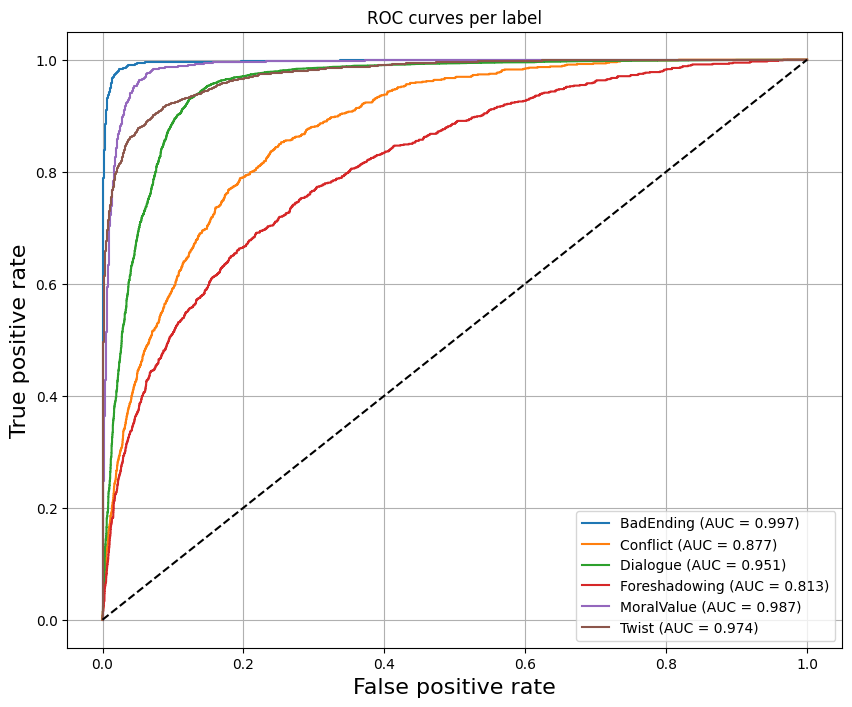

Area under the ROC curve: 0.9333


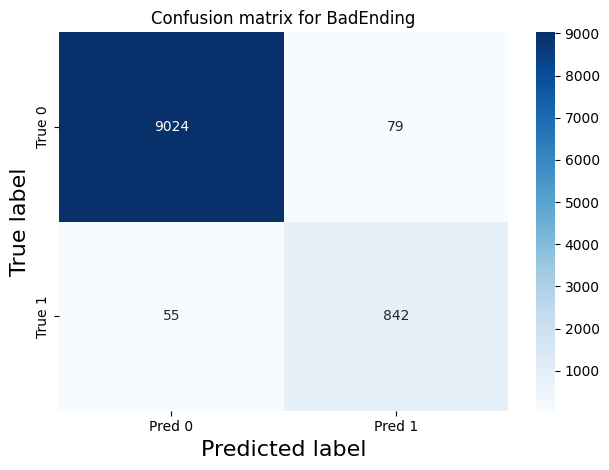

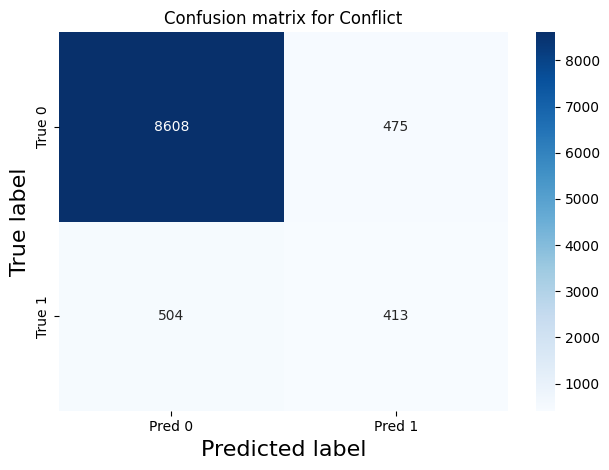

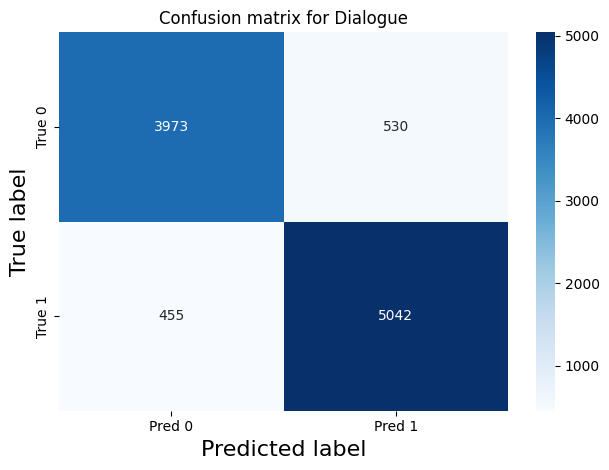

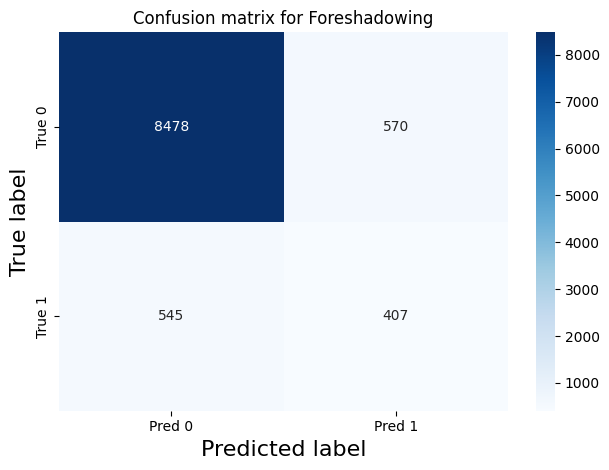

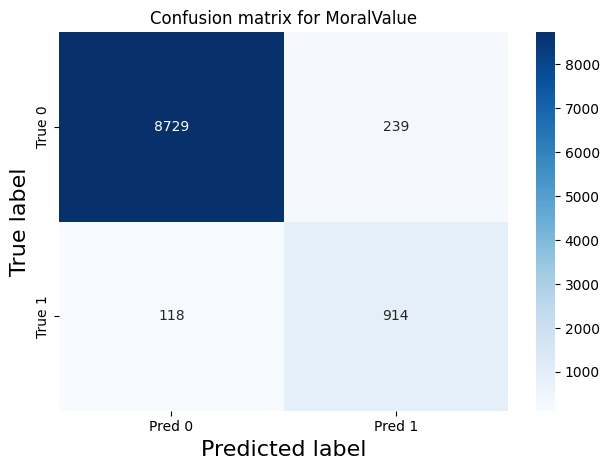

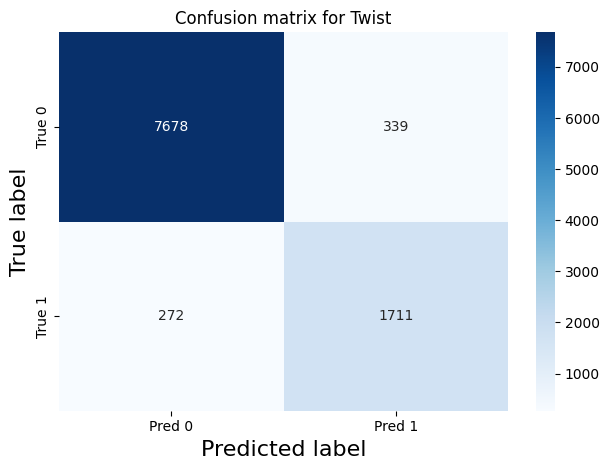

In [ ]:
roc_per_tag(y_test_true, y_test_probs, TAGS)
confusion_matrices(y_test_true, y_test_predictions, TAGS)